In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10 as dataset
#from keras.datasets import mnist as dataset

(X_train, y_train), (X_test, y_test) = dataset.load_data()
X_train = X_train.reshape( X_train.shape + (1,) if len(X_train.shape)==3 else X_train.shape )
X_test = X_test.reshape( X_test.shape + (1,) if len(X_test.shape)==3 else X_test.shape )
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
nb_classes = max(y_train) + 1
Y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

('X_train shape:', (50000, 32, 32, 3))
(50000, 'train samples')
(10000, 'test samples')


In [3]:
from keras.layers import Convolution2D, Activation, merge
from keras.layers.normalization import BatchNormalization
from keras import backend as K
                 
class ResnetBlock(object):
    def __init__(self, np_repeat, nb_filter, nb_row=3, nb_col=3, block_fn='basic',
                 init='glorot_uniform', subsample=(1, 1), dim_ordering='default',
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.nb_filter = nb_filter
        self.nb_row = nb_row
        self.nb_col = nb_col
        self.np_repeat = np_repeat
        if block_fn not in {'basic', 'bottleneck'}:
            raise ValueError('block_fn must be in {basic, bottlenect}.')
        self.block_fn = block_fn
        
        self.init = init

        self.subsample = tuple(subsample)
        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()
        self.dim_ordering = dim_ordering
        self.channel_axis = 3 if dim_ordering == 'tf' else 1

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.layers = []
        self.input_layers = None
        
    def build_step(self, input_shape):
        self.layers.append( BatchNormalization(mode=0, axis=self.channel_axis, input_shape=input_shape) )
        self.layers.append( Activation('relu') )
        if self.block_fn == 'basic':
            self.layers.append( Convolution2D(nb_filter=self.nb_filter, nb_row=self.nb_row, nb_col=self.nb_col,
                                              init=self.init, subsample=self.subsample, dim_ordering=self.dim_ordering,
                                              border_mode='same',
                                              W_regularizer=self.W_regularizer, b_regularizer=self.b_regularizer,
                                              W_constraint=self.W_constraint, b_constraint=self.b_constraint,
                                              bias=self.bias,
                                              input_shape=input_shape) )
        else:
            input_nb_filter = input_shape[self.channel_axis]
            self.layers.append( Convolution2D(nb_filter=self.input_nb_filter, nb_row=1, nb_col=1,
                                              init=self.init, subsample=self.subsample, dim_ordering=self.dim_ordering,
                                              border_mode='same',
                                              W_regularizer=self.W_regularizer, b_regularizer=self.b_regularizer,
                                              W_constraint=self.W_constraint, b_constraint=self.b_constraint,
                                              bias=self.bias,
                                              input_shape=input_shape) )
            self.layers.append( Convolution2D(nb_filter=self.input_nb_filter, nb_row=self.nb_row, nb_col=self.nb_col,
                                              init=self.init, subsample=self.subsample, dim_ordering=self.dim_ordering,
                                              border_mode='same',
                                              W_regularizer=self.W_regularizer, b_regularizer=self.b_regularizer,
                                              W_constraint=self.W_constraint, b_constraint=self.b_constraint,
                                              bias=self.bias,
                                              input_shape=input_shape) )
            self.layers.append( Convolution2D(nb_filter=self.nb_filter, nb_row=1, nb_col=1,
                                              init=self.init, subsample=self.subsample, dim_ordering=self.dim_ordering,
                                              border_mode='same',
                                              W_regularizer=self.W_regularizer, b_regularizer=self.b_regularizer,
                                              W_constraint=self.W_constraint, b_constraint=self.b_constraint,
                                              bias=self.bias,
                                              input_shape=input_shape) )
            
    

    def build(self, input_shape):
        assert len(input_shape) >= 4
        current_input_shape = input_shape
        for i in range(self.np_repeat):
            self.build_step(current_input_shape)
            current_input_shape = self.get_output_shape_for(current_input_shape)
            
        if not input_shape[self.channel_axis] == self.nb_filter:
            self.input_layers = Convolution2D(nb_filter=self.nb_filter, nb_row=1, nb_col=1, border_mode='same')
        self.built = True
        
    def call(self, x, mask=None):
        _ = x
        for layer in self.layers:
            _ = layer(_)
        return merge([_, self.input_layers(x) if self.input_layers else x], mode='sum')
    
    def __call__(self, x, mask=None):
        if not self.built:
            self.build(K.int_shape(x))
        return self.call(x)
        
    def get_output_shape_for(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = self.nb_filter
        return tuple(output_shape)


In [4]:
from keras.layers import Input, Convolution2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

inputs = Input(X_train.shape[1:])
_ = inputs
_ = Convolution2D(64, 7, 7, subsample=(2, 2), border_mode='same')(_)
_ = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), border_mode='same')(_)
_ = ResnetBlock(2, 64)(_)
_ = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same')(_)
_ = ResnetBlock(2, 128)(_)
_ = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same')(_)
_ = Flatten()(_)
_ = Dense(nb_classes, activation='softmax')(_)
outputs = _

model = keras.models.Model(input=inputs, output=outputs)
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

histories = []

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 16, 64)    9472        input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 8, 8, 64)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 8, 8, 64)      256         maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [5]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
                              samples_per_epoch=X_train.shape[0],
                              nb_epoch=10,
                              validation_data=(X_test, Y_test),
                              verbose=1)
histories.append(history)

Epoch 1/10
50000/50000 [==============================] - 185s - loss: 1.4190 - acc: 0.4918 - val_loss: 1.3538 - val_acc: 0.5225

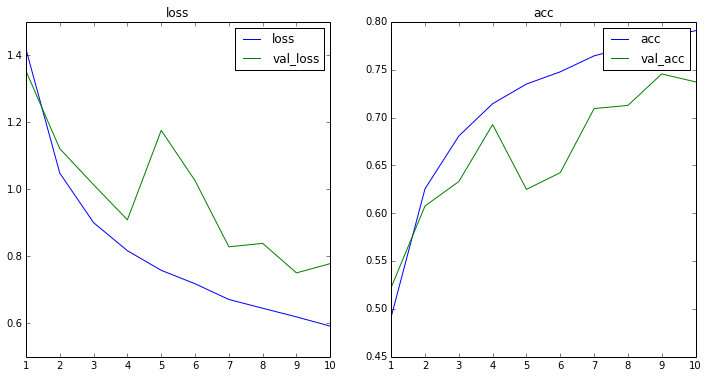

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 6))

metrics = ['loss', 'acc']
for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    for key in histories[0].history.keys():
        if not metric in key:
            continue
        values = [item for sublist in [history.history[key] for history in histories] for item in sublist]
        plt.plot( range(1, len(values)+1), values, label=key )
    plt.title(metric)
    plt.legend()

In [8]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
                              samples_per_epoch=X_train.shape[0],
                              nb_epoch=10,
                              validation_data=(X_test, Y_test),
                              verbose=1)
histories.append(history)

Epoch 1/10
50000/50000 [==============================] - 165s - loss: 0.5751 - acc: 0.7970 - val_loss: 0.7667 - val_acc: 0.7432

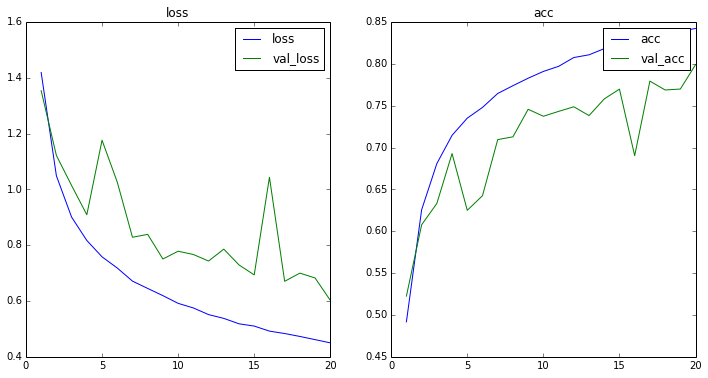

In [9]:
fig = plt.figure(figsize=(12, 6))

metrics = ['loss', 'acc']
for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    for key in histories[0].history.keys():
        if not metric in key:
            continue
        values = [item for sublist in [history.history[key] for history in histories] for item in sublist]
        plt.plot( range(1, len(values)+1), values, label=key )
    plt.title(metric)
    plt.legend()